In [255]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.linalg import block_diag, fractional_matrix_power
from dynamics import SatelliteDynamics
from utils import get_form_initial_conditions
from scipy.optimize import approx_fprime

In [256]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 20  # Duration [min]
T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # Number of states
n_y_1 = 3  # Number of measurements
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T

In [257]:
# Initial state vector and get the true state vectors (propagation) FIXME: Add run_propagation() here
X_initial = get_form_initial_conditions(formation)
X_true = np.zeros((24, 1, T))
X_true[:, :, 0] = X_initial
for t in range(T - 1):
    X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

# Process noise
q_chief_pos = 1e1  # [m]
q_chief_vel = 1e-1 # [m / s]
Q_chief = (
    np.diag(np.concatenate([q_chief_pos * np.ones(3), q_chief_vel * np.ones(3)]))
    ** 2
)
q_deputy_pos = 1e1  # [m]
q_deputy_vel = 1e-1  # [m / s]
Q_deputy = (
    np.diag(np.concatenate([q_deputy_pos * np.ones(3), q_deputy_vel * np.ones(3)]))
    ** 2
)
Q_deputies = block_diag(Q_deputy, Q_deputy, Q_deputy)
Q = block_diag(Q_chief, Q_deputies)

# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e1  # [m]
p_vel_initial = 1e-1  # [m / s]

In [258]:
def h_function_chief(x_vec):
    """
    Computes the measurement vector based on the current state vector.
    The measurement vector includes position components.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).
    """
    return x_vec[0:3]

def H_jacobian_chief():
    """
    Computes the Jacobian of the measurement function.
    """
    H = np.zeros((3, 24))
    H[0:3, 0:3] = np.eye(3)
    return H

def h_function_deputy(x_vec):
    """
    Computes the measurement vector based on the current state vector.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    y (np.array): The measurement vector of the satellite (range [km]).
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    return np.array(
        [
            [range_deputy1_chief],
            [range_deputy1_deputy2],
            [range_deputy1_deputy3],
            [range_deputy2_chief],
            [range_deputy2_deputy3],
            [range_deputy3_chief],
        ]
    )

def H_jacobian_deputy(x_vec):
    """
    Computes the Jacobian of the measurement function.

    Parameters:
    x_vec (np.array): The current state vector of the satellite (position [km] and velocity [km / s]).

    Returns:
    H (np.array): The Jacobian of the measurement function.
    """
    r_chief = x_vec[:3]
    r_deputy1 = x_vec[6:9]
    r_deputy2 = x_vec[12:15]
    r_deputy3 = x_vec[18:21]

    range_deputy1_chief = np.linalg.norm(r_deputy1 - r_chief)
    range_deputy1_deputy2 = np.linalg.norm(r_deputy1 - r_deputy2)
    range_deputy1_deputy3 = np.linalg.norm(r_deputy1 - r_deputy3)
    range_deputy2_chief = np.linalg.norm(r_deputy2 - r_chief)
    range_deputy2_deputy3 = np.linalg.norm(r_deputy2 - r_deputy3)
    range_deputy3_chief = np.linalg.norm(r_deputy3 - r_chief)

    H = np.zeros((6, 24))
    H[0, 0:3] = -(r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[0, 6:9] = (r_deputy1 - r_chief).reshape(-1) / range_deputy1_chief
    H[1, 6:9] = (r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[1, 12:15] = -(r_deputy1 - r_deputy2).reshape(-1) / range_deputy1_deputy2
    H[2, 6:9] = (r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[2, 18:21] = -(r_deputy1 - r_deputy3).reshape(-1) / range_deputy1_deputy3
    H[3, 0:3] = -(r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[3, 12:15] = (r_deputy2 - r_chief).reshape(-1) / range_deputy2_chief
    H[4, 12:15] = (r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[4, 18:21] = -(r_deputy2 - r_deputy3).reshape(-1) / range_deputy2_deputy3
    H[5, 0:3] = -(r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    H[5, 18:21] = (r_deputy3 - r_chief).reshape(-1) / range_deputy3_chief
    return H

def h(x_vec):
    return np.concatenate([h_function_chief(x_vec), h_function_deputy(x_vec)])

def H(x):
    return np.concatenate((H_jacobian_chief(), H_jacobian_deputy(x)))

In [259]:
# # Simulation setup
# X_est = np.zeros_like(X_true)
# initial_dev = np.concatenate(
#     (
#         p_pos_initial * np.random.randn(3, 1),
#         p_vel_initial * np.random.randn(3, 1),
#         p_pos_initial * np.random.randn(3, 1),
#         p_vel_initial * np.random.randn(3, 1),
#         p_pos_initial * np.random.randn(3, 1),
#         p_vel_initial * np.random.randn(3, 1),
#         p_pos_initial * np.random.randn(3, 1),
#         p_vel_initial * np.random.randn(3, 1),
#     )
# )
# X_est[:, :, 0] = X_initial + initial_dev
# for t in range(T - 1):
#     X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
X_est = np.zeros_like(X_true)
for t in range(T):
    Y[:, :, t] = h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    X_est[:, :, t] = X_true[:, :, t] + np.random.normal(0, np.sqrt(np.diag(Q)).reshape((24, 1)), size=(24, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [260]:
def r_function(X, Y):
    r = np.zeros(((4 * n_x + n_y_1 + n_y_2 + n_y_3 + n_y_4) * K, 1))
    # Process noise
    for k in range(K - 1):
        X_k = X[4 * n_x * k:4 * n_x * (k + 1)]
        X_k_1 = X[4 * n_x * (k + 1):4 * n_x * (k + 2)]
        r[k * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4):(k + 1) * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4), :] = fractional_matrix_power(Q, -1/2) @ (X_k_1 - SatelliteDynamics().x_new(dt, X_k))
    # Observation noise
    for k in range(K):
        X_k = X[4 * n_x * k:4 * n_x * (k + 1)]
        Y_k = Y[:, :, k]
        r[(k + 1) * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4):(k + 1) * 4 * n_x + (k + 1) * (n_y_1 + n_y_2 + n_y_3 + n_y_4), :] = fractional_matrix_power(R, -1/2) @ (Y_k - h(X_k))
    return r

def J_jacobian(X):
    J = np.zeros(((4 * n_x + n_y_1 + n_y_2 + n_y_3 + n_y_4) * K, 4 * n_x * K))
    for k in range(K):
        X_k = X[4 * n_x * k:4 * n_x * (k + 1)]
        _, F_k = SatelliteDynamics().x_new_and_F(dt, X_k)
        if k < K - 1:
            J[k * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4):(k + 1) * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4), k * 4 * n_x:(k + 1) * 4 * n_x] = -fractional_matrix_power(Q, -1/2) @ F_k
            J[k * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4):(k + 1) * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4), (k + 1) * 4 * n_x:(k + 2) * 4 * n_x] = fractional_matrix_power(Q, -1/2)
        J[(k + 1) * 4 * n_x + k * (n_y_1 + n_y_2 + n_y_3 + n_y_4):(k + 1) * 4 * n_x + (k + 1) * (n_y_1 + n_y_2 + n_y_3 + n_y_4), k * 4 * n_x:(k + 1) * 4 * n_x] = -fractional_matrix_power(R, -1/2) @ H(X_k)
    return J

def cost_function(X, Y):
    r = r_function(X, Y)
    return np.linalg.norm(r)**2

In [263]:
# Solution
lambda_0 = 1.0

x_bold_i = X_est.reshape(-1, 1, order='F')
lambda_i = lambda_0
i = 0
epsilon = 1e-2
max_iter = 100

grad_i_norms = []
costs = []
lambdas_i = []

while i < max_iter:
    r = r_function(x_bold_i, Y)
    J = J_jacobian(x_bold_i)

    # For plotting the results
    grad_i_norm = np.linalg.norm(J.T @ r)
    grad_i_norms.append(grad_i_norm)
    costs.append(cost_function(x_bold_i, Y))
    lambdas_i.append(lambda_i)

    if grad_i_norm < epsilon:
        print(f"STOOOOP\nIteration {i}\nGrad_i_norm = {grad_i_norm}\nx_pred_i cost = {cost_function(x_pred_i, Y)} | x_bold_i cost = {cost_function(x_bold_i, Y)}\nlambda_i = {lambda_i}\n")
        break

    # Solve for the update step
    delta_x = np.linalg.inv(J.T @ J + lambda_i * np.eye(J.shape[1])) @ J.T @ r

    x_pred_i = x_bold_i - delta_x

    print(f"Iteration {i}\nGrad_i_norm = {grad_i_norm}\nx_pred_i cost = {cost_function(x_pred_i, Y)} | x_bold_i cost = {cost_function(x_bold_i, Y)}\nlambda_i = {lambda_i}\n")
    
    if cost_function(x_pred_i, Y,) < cost_function(x_bold_i, Y):
        x_bold_i = x_pred_i
        lambda_i *= 0.7
    else:
        lambda_i *= 2.0

    i += 1
    
X_est = x_bold_i.reshape(K, 1, 24).T

print("Converged to:", x_bold_i)
print("Number of iterations:", i)
print("Final cost:", costs[-1])
print("Final grad norm:", grad_i_norms[-1])
print("RMSE:", np.sqrt(np.mean(np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0)**2)))

Iteration 0
Grad_i_norm = 7553.548892961025
x_pred_i cost = 2557.1089944869605 | x_bold_i cost = 582127.6968740209
lambda_i = 1.0

Iteration 1
Grad_i_norm = 96.60237743283129
x_pred_i cost = 535.3545852112635 | x_bold_i cost = 2557.1089944869605
lambda_i = 0.7

Iteration 2
Grad_i_norm = 18.462294306295043
x_pred_i cost = 215.57621215046623 | x_bold_i cost = 535.3545852112635
lambda_i = 0.48999999999999994

Iteration 3
Grad_i_norm = 6.738549683713048
x_pred_i cost = 128.7823350397515 | x_bold_i cost = 215.57621215046623
lambda_i = 0.3429999999999999

Iteration 4
Grad_i_norm = 3.2197551171033174
x_pred_i cost = 88.00896538968601 | x_bold_i cost = 128.7823350397515
lambda_i = 0.24009999999999992

Iteration 5
Grad_i_norm = 1.9694505134316498
x_pred_i cost = 61.64209902678688 | x_bold_i cost = 88.00896538968601
lambda_i = 0.16806999999999994

Iteration 6
Grad_i_norm = 1.3577087302045194
x_pred_i cost = 42.51866006411103 | x_bold_i cost = 61.64209902678688
lambda_i = 0.11764899999999995

Ite

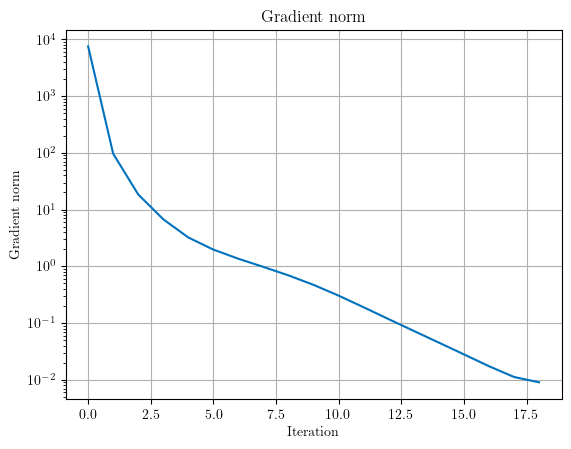

In [264]:
plt.figure()
plt.plot(grad_i_norms)
plt.title("Gradient norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid()
plt.yscale("log")
plt.show()

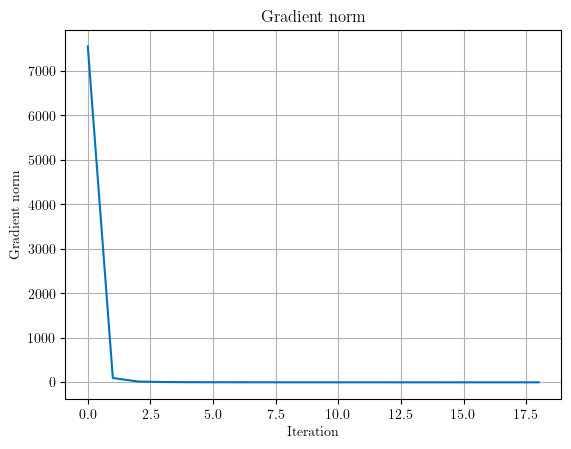

In [266]:
plt.figure()
plt.plot(grad_i_norms)
plt.title("Gradient norm")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid()
plt.show()

In [267]:
dev_chief = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1 = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2 = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3 = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

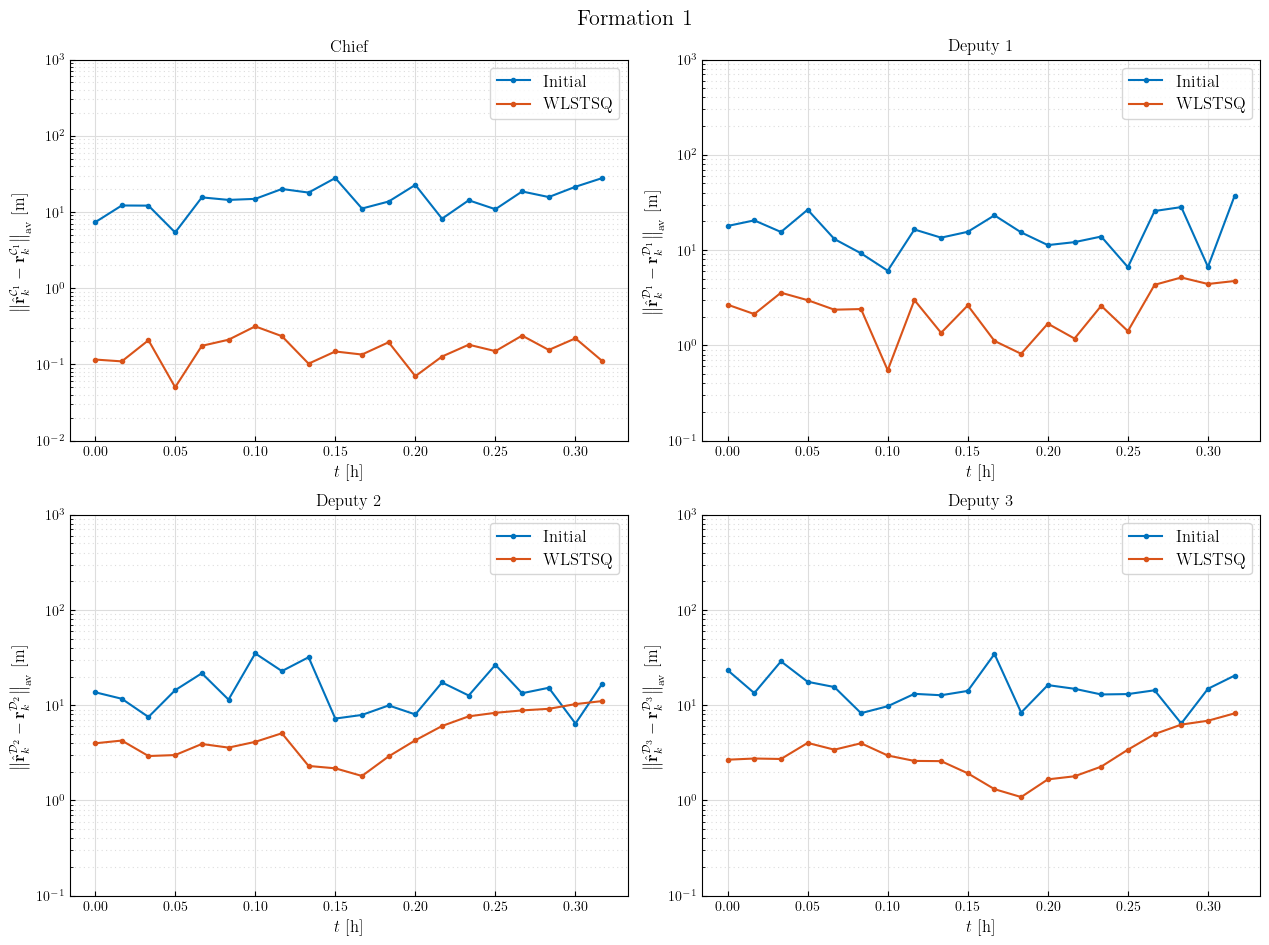

In [268]:
plt.rcParams.update(
    {"text.usetex": True, "font.family": "serif", "font.serif": "Computer Modern Roman"}
)
# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt
algorithm = "WLSTSQ"

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time, dev_chief, ".-", label=algorithm)
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time, dev_deputy1, ".-", label=algorithm)
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time, dev_deputy2, ".-", label=algorithm)
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time, dev_deputy3, ".-", label=algorithm)
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()